In [58]:
import numpy as np
from scipy.integrate import odeint
%matplotlib notebook
import matplotlib.pyplot as plt

In [59]:
%run System.ipynb

Hybrid system succesfully defined


In [60]:
# Define physical variables
gamma = 9.81
ci = 0.8 # Restitution coefficient robot-ball
cg = 0.8 # Restitution coefficient ball-ground
m1 = 0.5 # mass of the robot
m2 = 0.15 # mass of the ball
b1 = 0.2
b2 = 0.3

In [61]:
# Controller Variables
h = 0.5 # ball-robot desired distance in wait state
q2md = 1 # desired set point
kp = 30.0  # proportinal gain 
ki = 50.0 # integral gain
sigma = 10. # multiplicative constant
phi = 1
e_int = 2.0
kp_wait = 1e4
kd_wait = 1e3
kd_hit = 1e2
# measurement errors
sigma_q1 = 0.0
sigma_q2 = 0.0
sigma_p1 = 0.0

In [65]:
# Define Simulation parameters
# Time
Tspan = [0.0,20.0]  # simulation time
Jspan = 50  # discrete time span
Intervals = Tspan[1]*10 # nbr of intervals in which devide the time span
res = 100  # nbr of points in every interval
ts = Tspan[1]/Intervals # sampling time
# Initial Condition
xi0 = [2.0,1.5,0.0,0.0]

In [66]:
# Define Auxiliary simulation variables
state = 0
q2o = 0.0
p2o = 0.0
maxo = xi0[1]
#flag_jump = 0

In [67]:
# Define Flow map
def f(xi,t):
    q1 = xi[0]
    q2 = xi[1]
    p1 = xi[2]
    p2 = xi[3]
    u = IterEnergyShaping(xi,t)
    dq1dt = p1/m1
    dq2dt = p2/m2
    dp1dt = -m1*gamma - b1*p1/m1 + u
    dp2dt = -m2*gamma - b2*p2/m2
    return [dq1dt,dq2dt,dp1dt,dp2dt]

In [68]:
# Define Jump map
def g(xi):
    global state
    global flag_jump
    q1 = xi[0]
    q2 = xi[1]
    p1 = xi[2]
    p2 = xi[3]
    if not flag_jump:
        # Resolve collision ball-ground
        xip = [q1,q2,p1,-cg*p2]
        state = 0
        #print('-> bg collision resolved')
    else:
        # Resolve collision ball-robot
        l = (ci+1)/(m1+m2)
        dp = m2*p1 - m1*p2
        xip = [q1,q2,p1-l*dp,p2+l*dp]      
        state = 0
        #print('-> br collision resolved')
    return xip

In [69]:
# Define flow set
def C(xi):
    x = xi[0]
    v = xi[1]
    inside = 1
    if x < 0:
        inside = 0
    return inside

In [70]:
# Define jump set
def D(xi):
    global state
    global flag_jump
    global hit
    q1 = xi[0]
    q2 = xi[1]
    p1 = xi[2]
    p2 = xi[3]
    if ((q2<=0) and (p2<0)):
        jump = 1
        flag_jump = 0
        hit = 1
        state = 0
        print('-> B-G collision')
    elif (q1-q2)<=0:
        sp1 = np.sign(p1)
        sp2 = np.sign(p2)
        if (sp1>=0) and (sp2>=0) and (p2/m2>=p1/m1):
            jump = 1
            flag_jump = 1
            hit = 1
            state = 0
            print('-> R-B collision')
        elif (sp1<=0) and (sp2>=0):
            jump = 1
            flag_jump = 1
            hit = 1
            state = 0
            print('-> R-B collision')
        elif (sp1<=0) and (sp2<=0) and (abs(p2/m2)<=abs(p1/m1)):
            jump = 1
            flag_jump = 1
            hit = 1
            state = 0
            print('-> R-B collision')
        else:
            jump = 0
    else:
        jump = 0
    return jump

In [71]:
def DetectMax(q,p):
    global q2o
    global p2o
    global maxo
    sp2 = np.sign(p2o)
    if (np.sign(p)!=sp2) and (sp2==1):
        flag = 1
        maxi = 0.5*(q+q2o)
        maxo = maxi
    else:
        flag = 0
        maxi = maxo
    q2o = q
    p2o = p
    return [flag,maxi]

In [72]:
# Compute the Iterative Energy Shaping control action
def IterEnergyShaping(xi,t):
    global hit
    global state
    global e_int
    global phi
    # data variables
    global err
    global gain
    #
    nq1 = sigma_q1*np.sin(10000*t + 2.0) 
    nq2 = sigma_q2*np.sin(11000*t + 1.0)
    np1 = sigma_p1*np.sin(12000*t + 0.5)
    #
    q1 = xi[0] + nq1
    q2 = xi[1] + nq2
    p1 = xi[2] + np1
    p2 = xi[3]
    # Detect if the ball has reached the peak
    [flag,maxi] = DetectMax(q2,p2)
    # Determine Controller state and update the learning control loop
    if flag and hit:
        e = q2md-maxi
        e_int += e
        phi = sigma*(kp*e + ki*e_int)
        hit = 0
        state = 1
        err = np.append(err,e)
        gain = np.append(gain,phi)
        print('Peak Detected at','%.4f' % maxi)
        print(' Error:','%.4f'% e)
        print(' Cumulative Error:','%.4f'% e_int)
    # Compute control action
    if state:
        q1d = q2
        beta = m1*gamma - phi*(q1-q1d)
        v = -kd_hit*p1
    elif not state:
        q1d = q2 + h 
        beta = m1*gamma - 2*kp_wait*(q1-q1d)
        v = -kd_wait*p1
    else:
        beta =  0
        v = 0
    return beta + v
    #return 0 

In [73]:
# Initialize
i = 1 # count number of iterations
j = 0 # count number of jump
tsim = [0.0]
xi = np.empty((0,4))
err = [0.0]
gain = [0.0]
print('Starting simulation with sampling time',ts/res)
print('Total of evaluation points:', res*Intervals*Tspan[1])
print('Start...')
#print(xi.shape)
# Perform Simulation
while i<=Intervals and j<Jspan:
    # integrate the equation in ti
    ti = np.linspace(0,ts,res)
    x = odeint(f,xi0,ti)
    # reset the initial condition
    xi0 = x[-1,:]
    # check for jumps in the interval and, in case, run the jump map
    for k in range(0, res):
        if D(x[k,:]):
            print('Jump',j,'detected at time','%.4f' % float(ti[k]+tsim[-1]))
            #print('  xi=',x[k,:])
            xi0 = g(x[k,:])
            #print('  xi+=',xi0)
            ti = ti[0:k]
            x = x[0:k,:]
            j += 1 
            break
    # save the partial results
    tn = ti+tsim[-1]*np.ones(ti.shape[0])
    tsim  = np.append(tsim,tn)
    xi = np.append(xi,x,axis=0)
    # increment the iteration counter
    i += 1
print('Done.')

Starting simulation with sampling time 0.001
Total of evaluation points: 400000.0
Start...
-> B-G collision
Jump 0 detected at time 0.6768
Peak Detected at 0.3121
 Error: 0.6879
 Cumulative Error: 2.6879
-> B-G collision
Jump 1 detected at time 1.1848
Peak Detected at 0.1141
 Error: 0.8859
 Cumulative Error: 3.5738
-> B-G collision
Jump 2 detected at time 1.4909
Peak Detected at 0.0516
 Error: 0.9484
 Cumulative Error: 4.5221
-> R-B collision
Jump 3 detected at time 1.6374
-> B-G collision
Jump 4 detected at time 1.6475
Peak Detected at 0.3440
 Error: 0.6560
 Cumulative Error: 5.1781
-> R-B collision
Jump 5 detected at time 1.9323
-> B-G collision
Jump 6 detected at time 1.9919
Peak Detected at 0.6304
 Error: 0.3696
 Cumulative Error: 5.5477
-> R-B collision
Jump 7 detected at time 2.3495
-> B-G collision
Jump 8 detected at time 2.4505
Peak Detected at 0.7254
 Error: 0.2746
 Cumulative Error: 5.8223
-> R-B collision
Jump 9 detected at time 2.8253
-> B-G collision
Jump 10 detected at ti

In [74]:
tsim = tsim[1:]

In [75]:
q1 = xi[:,0]
q2 = xi[:,1]
p1 = xi[:,2]
p2 = xi[:,3]

<IPython.core.display.Javascript object>


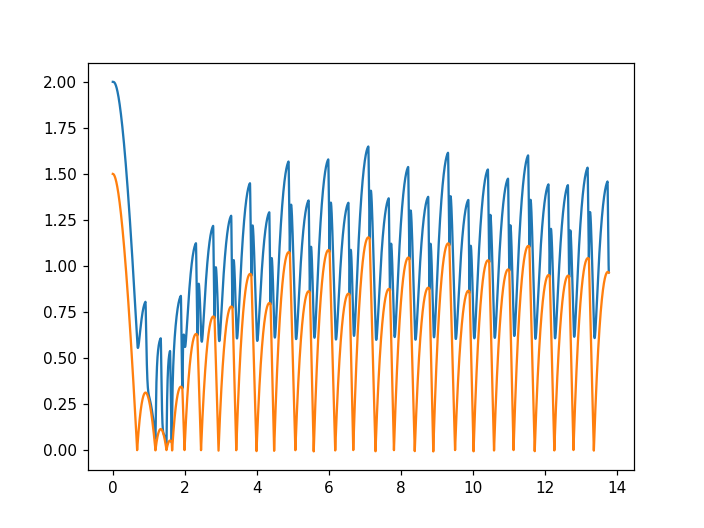

In [76]:
plt.figure(1)
#plt.subplot(211)
plt.plot(tsim,q1)
#plt.subplot(212)
plt.plot(tsim,q2)

<IPython.core.display.Javascript object>


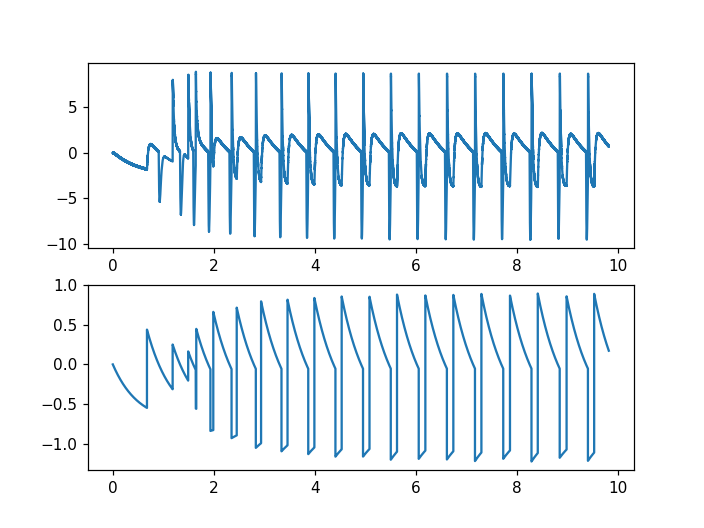

In [17]:
plt.figure(2)
plt.subplot(211)
plt.plot(tsim,p1)
plt.subplot(212)
plt.plot(tsim,p2)

<IPython.core.display.Javascript object>


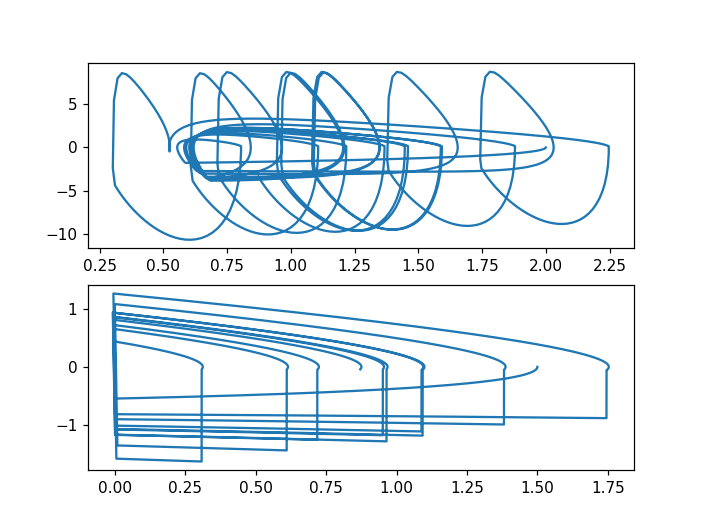

In [55]:
plt.figure(3)
plt.subplot(211)
plt.plot(q1,p1)
plt.subplot(212)
plt.plot(q2,p2)

In [ ]:
# Compute the energy of the system
#H = 0.5*np.power(p1,2)/m1 + m1*gamma*q1 + 0.5*np.power(p2,2)/m2 + m2*gamma*q2

In [56]:
#plt.figure(4)
#plt.plot(tsim,H)

<IPython.core.display.Javascript object>


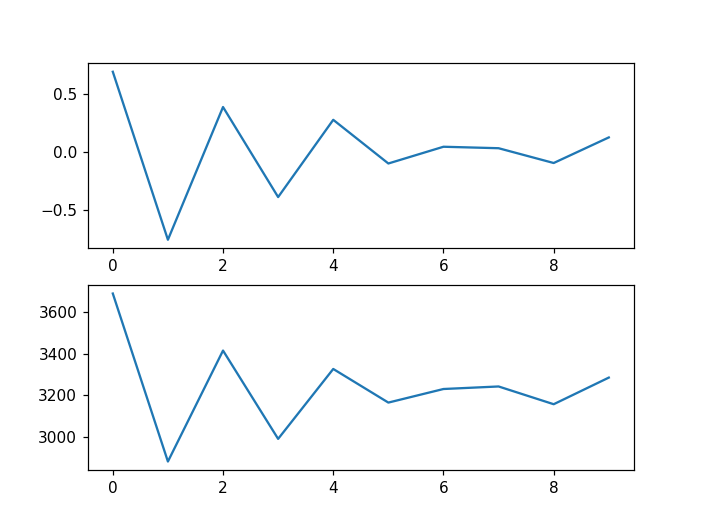

In [57]:
plt.figure(5)
plt.subplot(211)
plt.plot(err[1:])
plt.subplot(212)
plt.plot(gain[1:])

In [ ]:
#plt.figure(6)
#plt.plot(ctrl_beta[1:])
#plt.plot(ctrl_v[:1])

In [ ]:
#ctrl_beta.shape